## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import re
import scipy.stats as sc
import scipy as scipy
import metpy as mtp
import math
from scipy import integrate
import pandas as pd
import os
import random

from matplotlib.pyplot import cm
from matplotlib.collections import LineCollection
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

times = pd.date_range('1980-01-01', '2018-12-31 18:00:00', freq='1M')

In [4]:

def normalize_time_series(time_series):
    
    return (time_series - np.mean(time_series)) / np.std(time_series)

### Load instantaneous AHT calcs

In [90]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

final_ds = xr.open_dataset('../aht_time_series/aaron_aht_data_through_2018_with_time.nc')

### Load stream functions

In [105]:
strm_ds = xr.open_dataset('strm_functions.nc').sel(time=slice('1980','2018'))

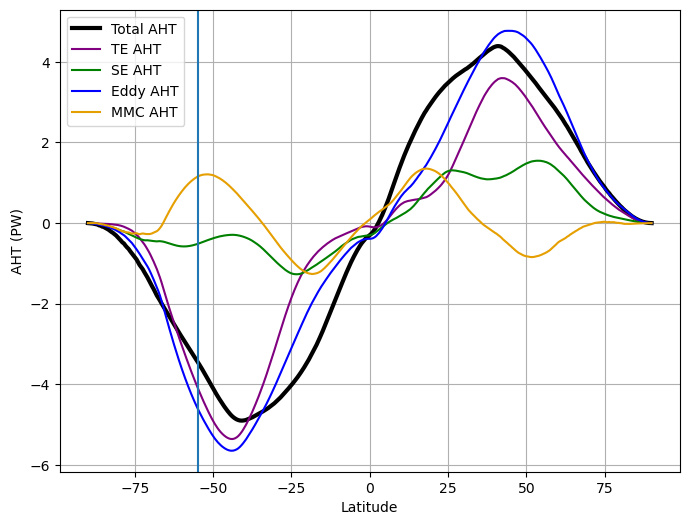

In [92]:
plt.figure(figsize=(8,6))

aht_clima = final_ds.mean(['time'])

plt.plot(lats, aht_clima.total_aht / 1e15, color='k', lw=3, label='Total AHT')
plt.plot(lats, aht_clima.te_aht / 1e15, color='purple', label='TE AHT')
plt.plot(lats, aht_clima.se_aht / 1e15, color='g', label='SE AHT')
plt.plot(lats, (aht_clima.se_aht + aht_clima.te_aht) / 1e15, color='b', label='Eddy AHT')
plt.plot(lats, aht_clima.mmc_aht / 1e15, color='#E69F00', label='MMC AHT')

plt.axvline(-55)

plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')

#plt.savefig('../figures/general_exam_plots/aht_clima_tot_only')
plt.show()

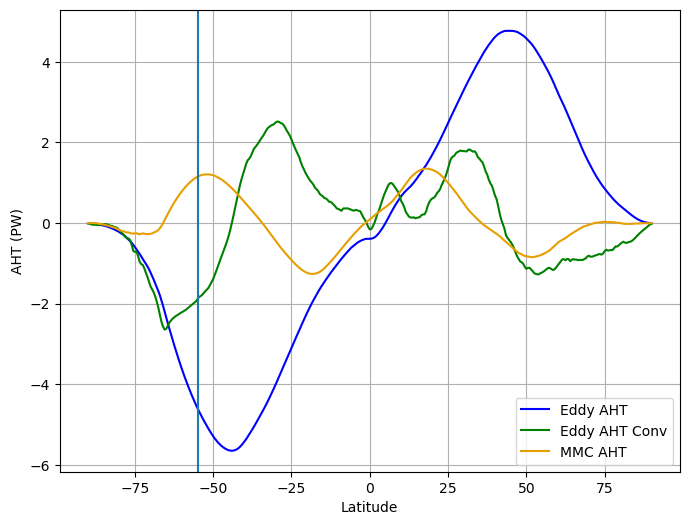

In [132]:
plt.figure(figsize=(8,6))

aht_clima = final_ds.mean(['time'])

plt.plot(lats, (aht_clima.se_aht + aht_clima.te_aht) / 1e15, color='b', label='Eddy AHT')
plt.plot(lats, (aht_clima.te_aht).differentiate('latitude') / 1e14,
         color='g', label='Eddy AHT Conv')
plt.plot(lats, aht_clima.mmc_aht / 1e15, color='#E69F00', label='MMC AHT')

plt.axvline(-55)

plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')

#plt.savefig('../figures/general_exam_plots/aht_clima_tot_only')
plt.show()

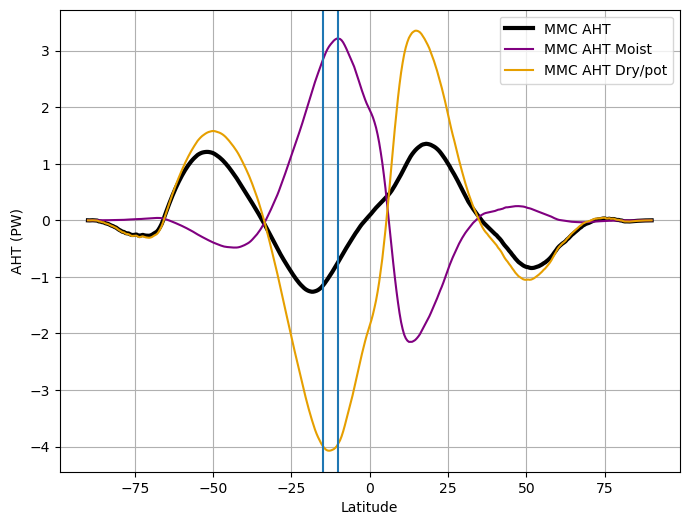

In [10]:
plt.figure(figsize=(8,6))

aht_clima = final_ds.mean(['time'])

plt.plot(lats, aht_clima.mmc_aht / 1e15, color='k', lw=3, label='MMC AHT')
plt.plot(lats, aht_clima.mmc_aht_moist / 1e15, color='purple', label='MMC AHT Moist')
plt.plot(lats, aht_clima.mmc_aht_dry_pot / 1e15, color='#E69F00', label='MMC AHT Dry/pot')

plt.axvline(-10)
plt.axvline(-15)

plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')

#plt.savefig('../figures/general_exam_plots/aht_clima_tot_only')
plt.show()

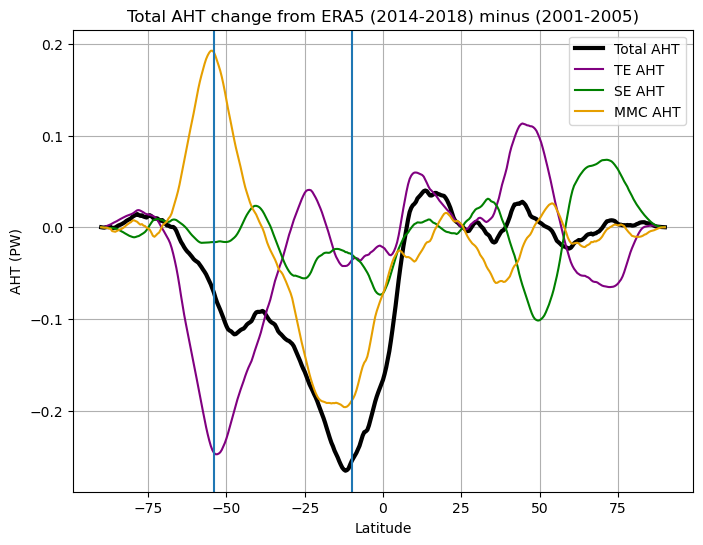

In [24]:
plt.figure(figsize=(8,6))

aht_change = final_ds.sel(time=slice('2009-01-01', '2018-12-31')).mean(['time']) - final_ds.sel(time=slice('1980-01-01', '1989-12-31')).mean(['time'])
#For ceres only timeframe
#aht_change = final_ds.sel(time=slice('2014-01-01', '2018-12-31')).mean(['time']) - final_ds.sel(time=slice('2001-01-01', '2005-12-31')).mean(['time'])


plt.plot(lats, aht_change.total_aht / 1e15, color='k', lw=3, label='Total AHT')
plt.plot(lats, aht_change.te_aht / 1e15, color='purple', label='TE AHT')
plt.plot(lats, aht_change.se_aht / 1e15, color='g', label='SE AHT')
plt.plot(lats, aht_change.mmc_aht / 1e15, color='#E69F00', label='MMC AHT')


#plt.plot(lats, aht_change.mmc_aht / 1e15, color='k', lw=3, label='Total')
#plt.plot(lats, aht_change.total_aht_dry / 1e15, color='r', lw=3, label='Dry AHT')
#plt.plot(lats, aht_change.mmc_aht_moist / 1e15, color='b', label='Moist AHT')
#plt.plot(lats, aht_change.total_aht_pot / 1e15, color='g', label='Pot AHT')
#plt.plot(lats, aht_change.mmc_aht_dry_pot / 1e15, color='g', label='Dry + Pot AHT')

plt.axvline(-10)
plt.axvline(-54)
plt.grid()
plt.legend(loc=0)

plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')
plt.title('Total AHT change from ERA5 (2014-2018) minus (2001-2005)')
#plt.savefig('../figures/5_24_22_meeting/aht_changes_era5_ceres_era')
plt.show()

### Lets see if Ferrel and Eddys compensate on yearly time scales

-0.6796553476930017
0.5260237708645902


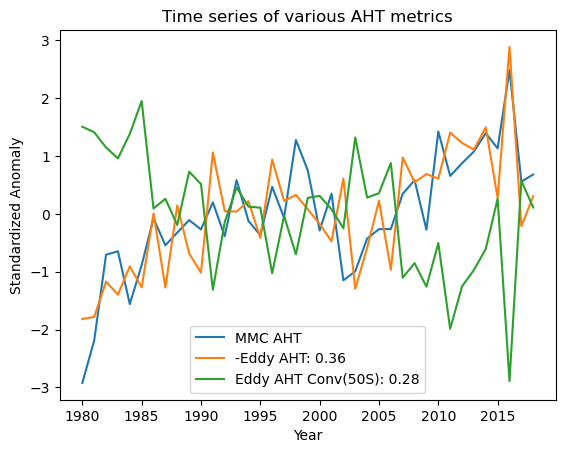

In [147]:
mmc_aht_time_series = final_ds.mmc_aht.sel(latitude=-55).groupby('time.year').mean(['time'])
te_aht_time_series = final_ds.te_aht.sel(latitude=-55).groupby('time.year').mean(['time'])
eddy_aht_time_series = (final_ds.te_aht + final_ds.se_aht).sel(latitude=-55).groupby('time.year').mean(['time'])

te_aht_conv_time_series = -final_ds.te_aht.differentiate('latitude').sel(latitude=-55).groupby('time.year').mean(['time'])
eddy_aht_conv_time_series = -(final_ds.te_aht + final_ds.se_aht).differentiate('latitude').sel(latitude=slice(-55, -75)).groupby('time.year').mean(['time', 'latitude'])

te_aht_corrcoef = np.corrcoef(signal.detrend(normalize_time_series(mmc_aht_time_series)),
                 signal.detrend(normalize_time_series(te_aht_time_series)))[1,0]

eddy_aht_corrcoef = np.corrcoef(signal.detrend(normalize_time_series(mmc_aht_time_series)),
                 signal.detrend(normalize_time_series(eddy_aht_time_series)))[1,0]

te_conv_corrcoef = np.corrcoef(signal.detrend(normalize_time_series(mmc_aht_time_series)),
                 signal.detrend(normalize_time_series(te_aht_conv_time_series)))[1,0]

eddy_conv_corrcoef = np.corrcoef(signal.detrend(normalize_time_series(mmc_aht_time_series)),
                 signal.detrend(normalize_time_series(eddy_aht_conv_time_series)))[1,0]

plt.plot(range(1980, 2019), normalize_time_series(mmc_aht_time_series), label='MMC AHT')
#plt.plot(range(1980, 2019), -normalize_time_series(te_aht_time_series), label='-TE AHT: ' + str(round(te_aht_corrcoef**2, 2)))
#plt.plot(range(1980, 2019), -normalize_time_series(te_aht_conv_time_series),
         #label='TE AHT Conv(55S): ' + str(round(te_conv_corrcoef**2, 2)))
plt.plot(range(1980, 2019), -normalize_time_series(eddy_aht_time_series), 
         label='-Eddy AHT: ' + str(round(eddy_aht_corrcoef**2, 2)))
plt.plot(range(1980, 2019), -normalize_time_series(eddy_aht_conv_time_series), 
         label='Eddy AHT Conv(50S): ' + str(round(eddy_conv_corrcoef**2, 2)))


print(te_aht_corrcoef)

print(eddy_conv_corrcoef)

plt.legend(loc=0)

plt.xlabel('Year')
plt.ylabel('Standardized Anomaly')

plt.title('Time series of various AHT metrics')

#plt.savefig('../figures/aht_changes/mmc_aht_negative_te_aht_eddy_conv_50S_stnd_time_series_55S')
#plt.savefig('../figures/aht_changes/mmc_aht_negative_eddy_aht_stnd_time_series_55S')

plt.show()

### Look at trends in Ferrel AHT and Stream functions

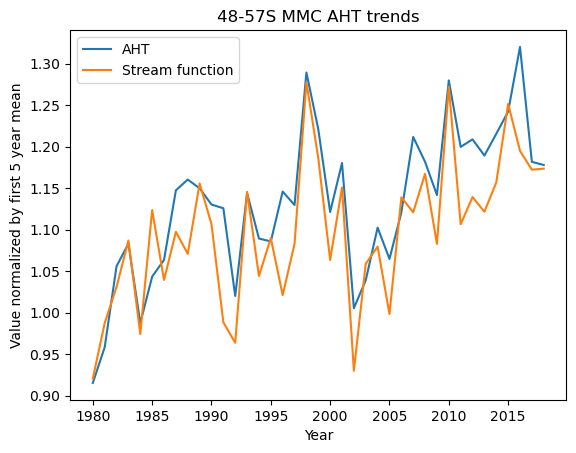

In [126]:
ferrel_aht = final_ds.mmc_aht.sel(latitude=slice(-48, -57)).groupby('time.year').mean(['time', 'latitude'])
ferrel_strm = strm_ds.strm_fnct.sel(latitude=slice(-48, -57), level=700).groupby('time.year').mean(['time', 'latitude'])


plt.plot(range(1980, 2019), ferrel_aht / np.mean(ferrel_aht[0:5]), label='AHT')
plt.plot(range(1980, 2019), ferrel_strm / np.mean(ferrel_strm[0:5]), label='Stream function')

plt.legend(loc=0)

plt.ylabel('Value normalized by first 5 year mean')
plt.xlabel('Year')

plt.title('48-57S MMC AHT trends')
#plt.title('55S MMC AHT and Streamfunction (700hPa) trends')

#plt.savefig('../figures/aht_changes/mmc_aht_strm_fnction_700hPa_48_to_57S_norm_by_1st_5_year_mean')

plt.show()

### Annual compensation trends

0.2693228630076753


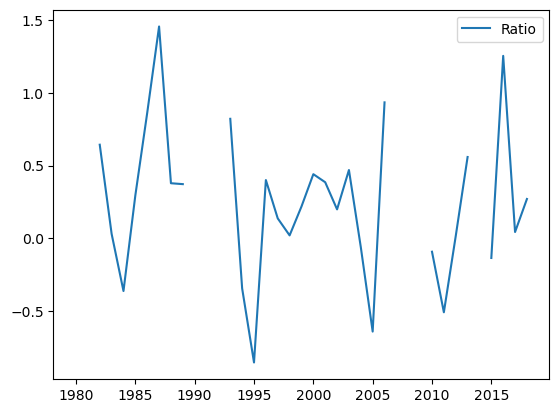

In [191]:
mmc_aht_time_series = final_ds.mmc_aht.sel(latitude=-60).groupby('time.year').mean(['time'])
te_aht_time_series = final_ds.te_aht.sel(latitude=-60).groupby('time.year').mean(['time'])

te_no_mean = te_aht_time_series - np.mean(te_aht_time_series)
mmc_no_mean = mmc_aht_time_series - np.mean(mmc_aht_time_series)

te_no_trend = signal.detrend(te_aht_time_series)
mmc_no_trend = signal.detrend(mmc_aht_time_series)

#plt.plot(range(1980, 2019), mmc_no_trend, label='MMC AHT')
#plt.plot(range(1980, 2019), te_no_trend, label='TE AHT')

ratio = -(mmc_no_trend) / (te_no_trend)

ratio[abs(te_no_trend)<0.01e14] = np.nan
ratio[abs(ratio)>1.5] = np.nan

plt.plot(range(1980, 2019), ratio, label='Ratio')
#plt.ylim([-1, 1])

print(np.nanmean(ratio))
plt.legend(loc=0)

plt.show()